In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wfdb
import pywt
from scipy.signal import resample

import numba

In [2]:
data_path = "incart_database/files"

In [13]:
with open("incart_database/files/RECORDS") as f:
    records = f.readlines()

In [14]:
records = [r.strip() for r in records]

In [15]:
# signal, description = wfdb.rdsamp(f"{data_path}/{records[0]}")

In [16]:
# signal.T.shape

In [20]:
diseases = []
for r in records:
    signal, description = wfdb.rdsamp(f"{data_path}/{r}")
    comments = description['comments'][0]
    tag = "<diagnoses>"
    idx = comments.find(tag)
    if idx == -1:
        diagnosis = "Normal"
    else:
        diagnosis = comments[idx+len(tag):].strip()
    diseases.append(diagnosis)

In [21]:
description['fs']

257

In [22]:
description['sig_len']

462600

In [23]:
disease_counts = {}
for d in diseases:
    if disease_counts.get(d, None):
        disease_counts[d] += 1
    else:
        disease_counts[d] = 1

In [24]:
disease_counts

{'Coronary artery disease, arterial hypertension': 6,
 'Acute MI': 6,
 'Transient ischemic attack': 7,
 'Normal': 34,
 'Coronary artery disease, arterial hypertension, left ventricular hypertrophy': 11,
 'Earlier MI': 9,
 'Sinus node dysfunction': 2}

In [25]:
original_sampling_rate = 257  # Hz
target_sampling_rate = 100  # Hz
# Calculate downsampling factor
dsf = original_sampling_rate / target_sampling_rate
# Calculate new signal length
new_signal_length = description['sig_len'] / dsf
new_signal_length

180000.0

In [26]:
downsamp = resample(signal, num=int(new_signal_length))
downsamp.shape

(180000, 12)

In [27]:
signals_downsamp = downsamp.reshape(180, 1000, 12)

In [28]:
signals_downsamp[0].shape

(1000, 12)

In [29]:
signal.shape

(462600, 12)

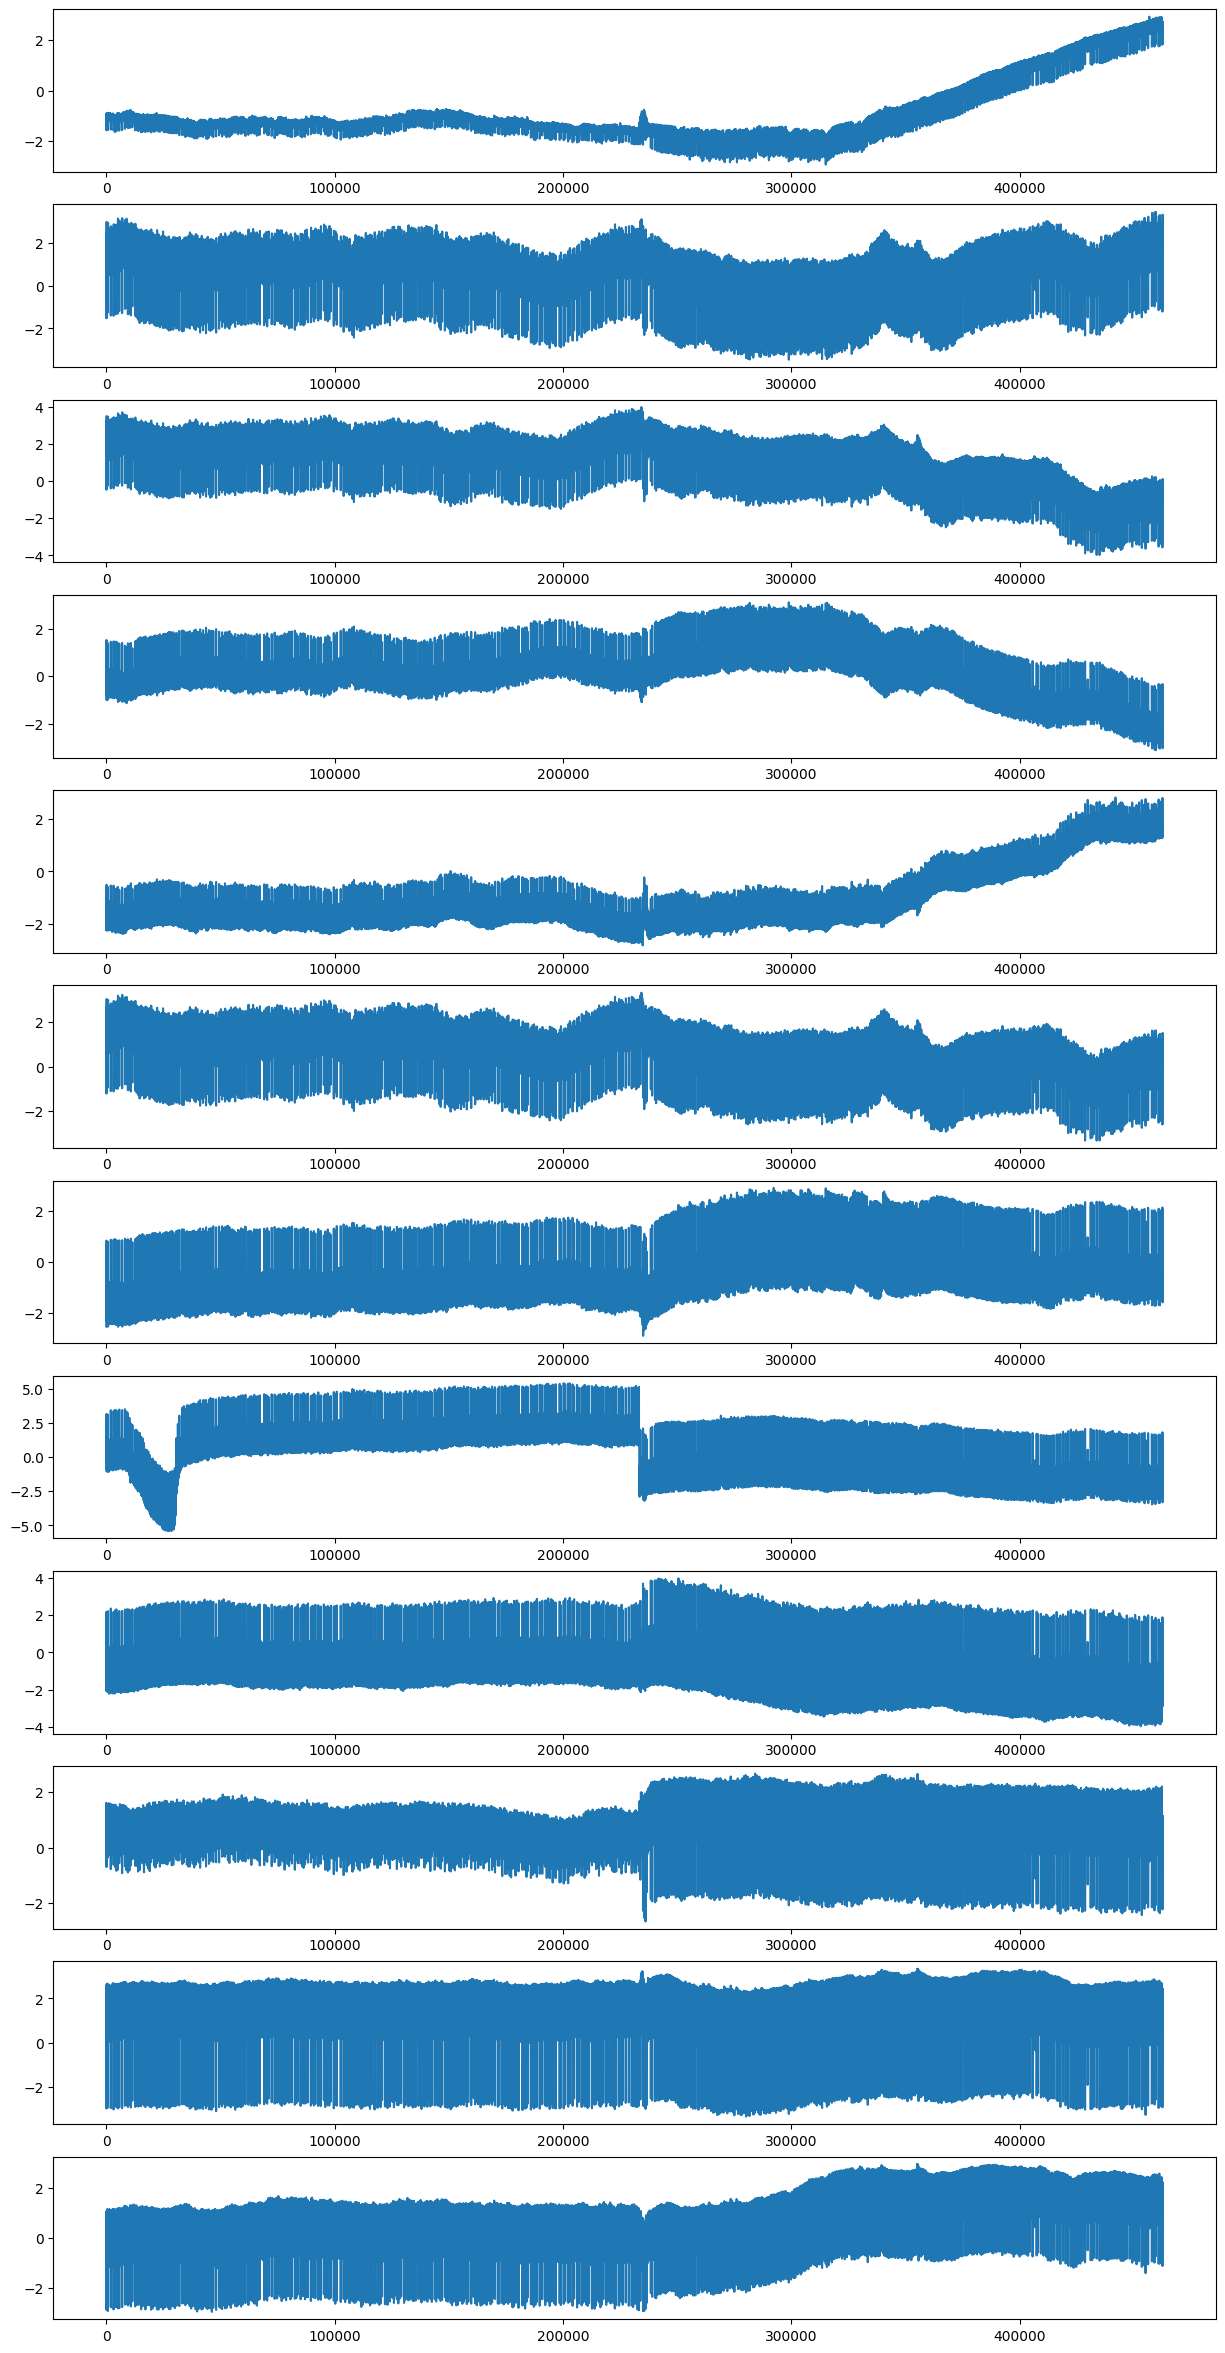

In [30]:
fig, ax = plt.subplots(12, 1, figsize=(15, 30))
for i, axis in enumerate(ax):
    axis.plot(signal[:, i])

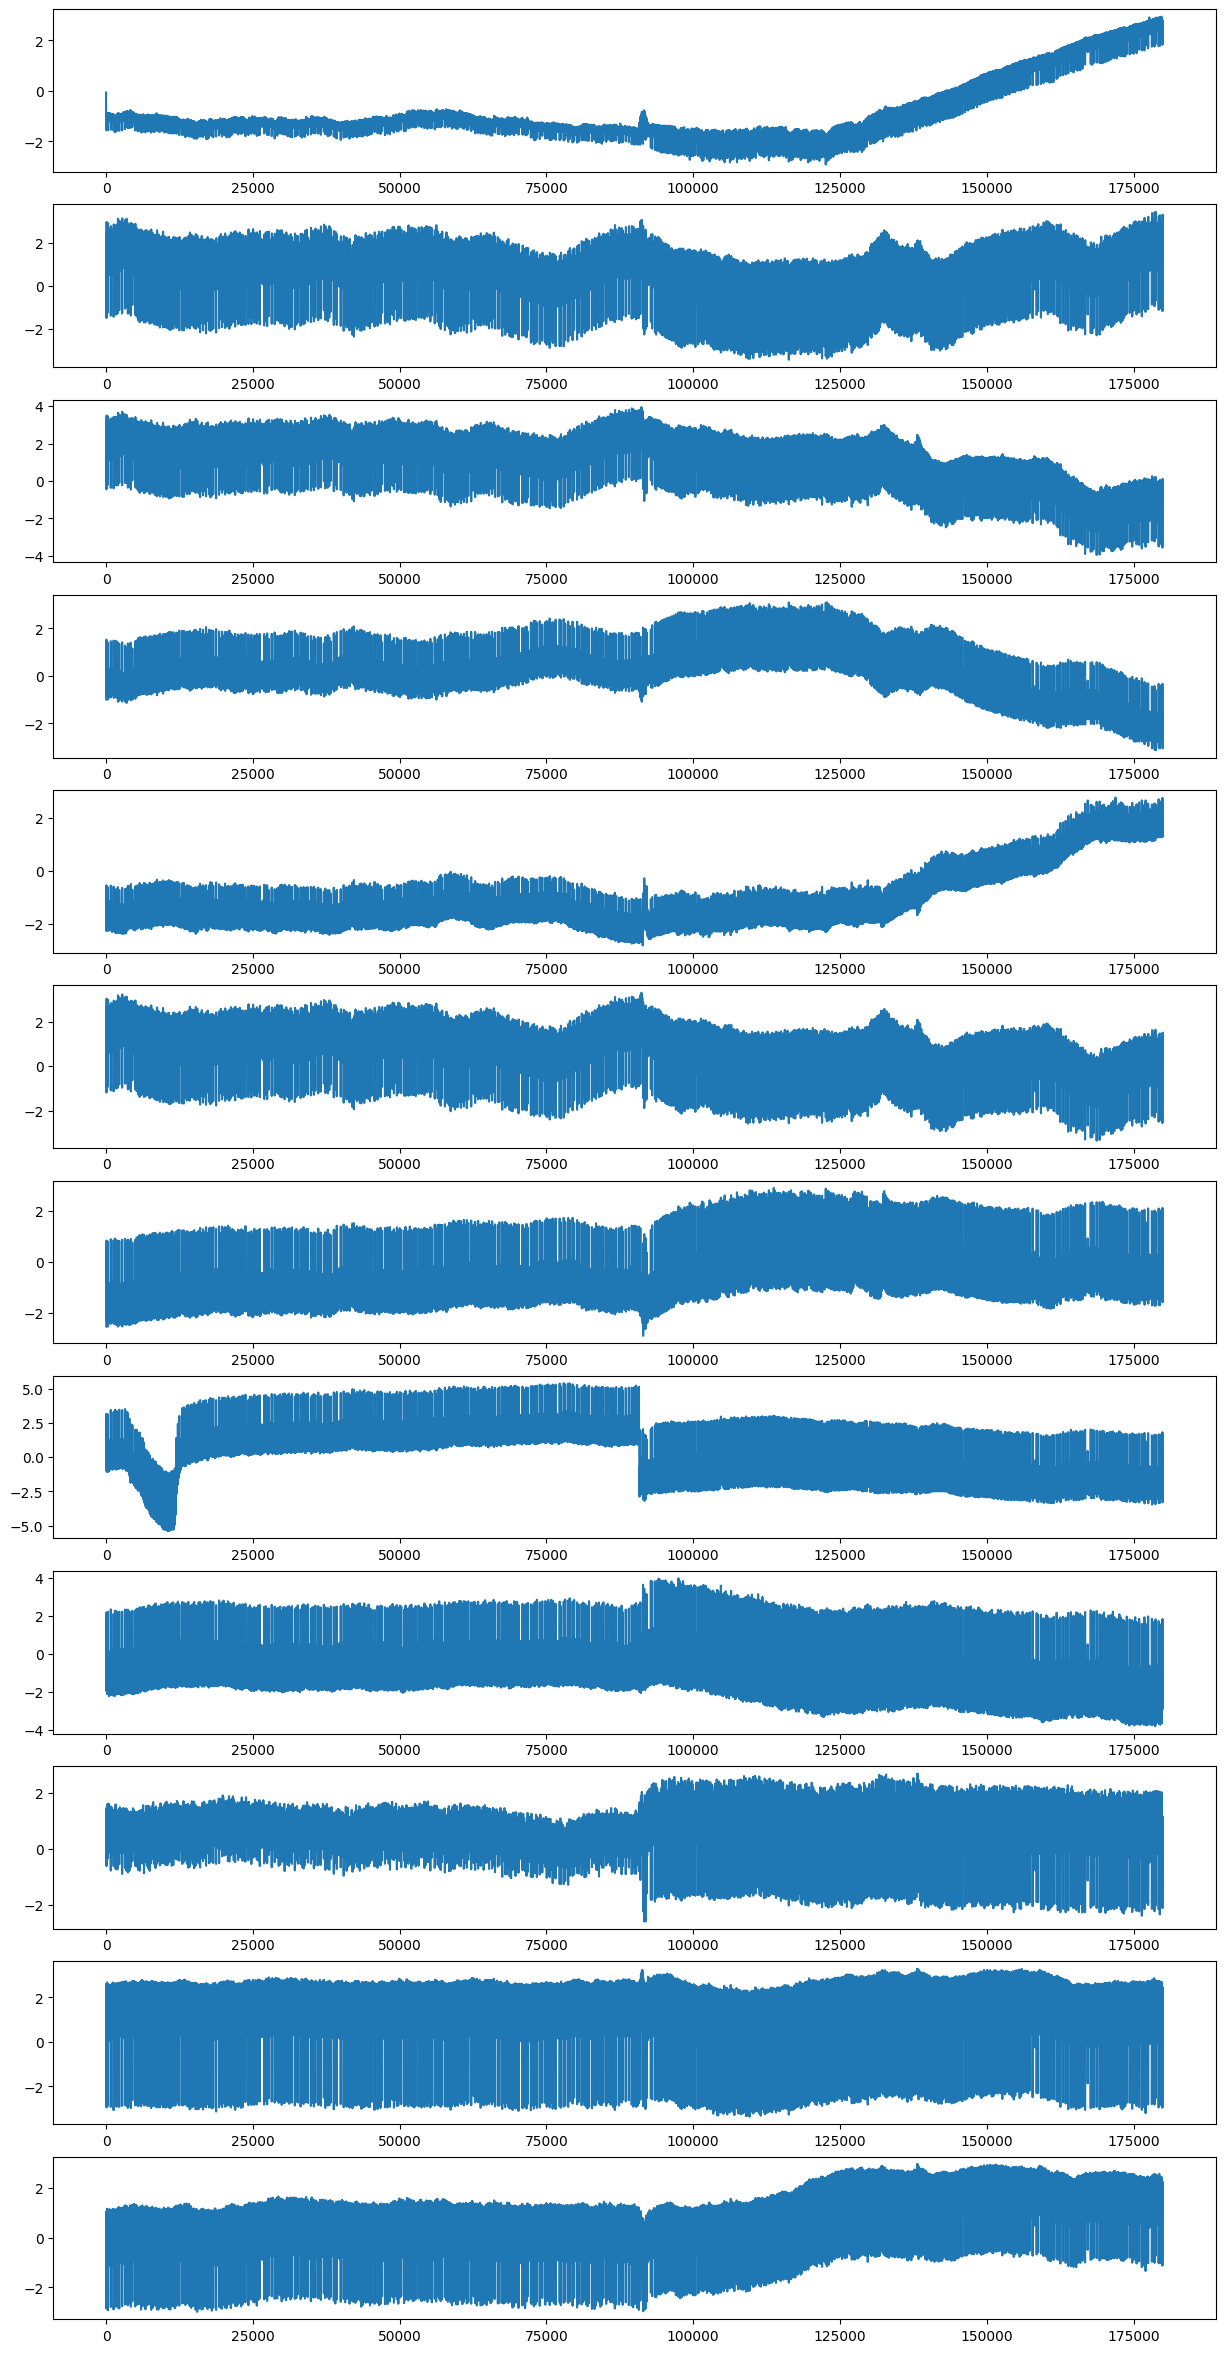

In [25]:
fig, ax = plt.subplots(12, 1, figsize=(15, 30))
for i, axis in enumerate(ax):
    axis.plot(downsamp[:, i])

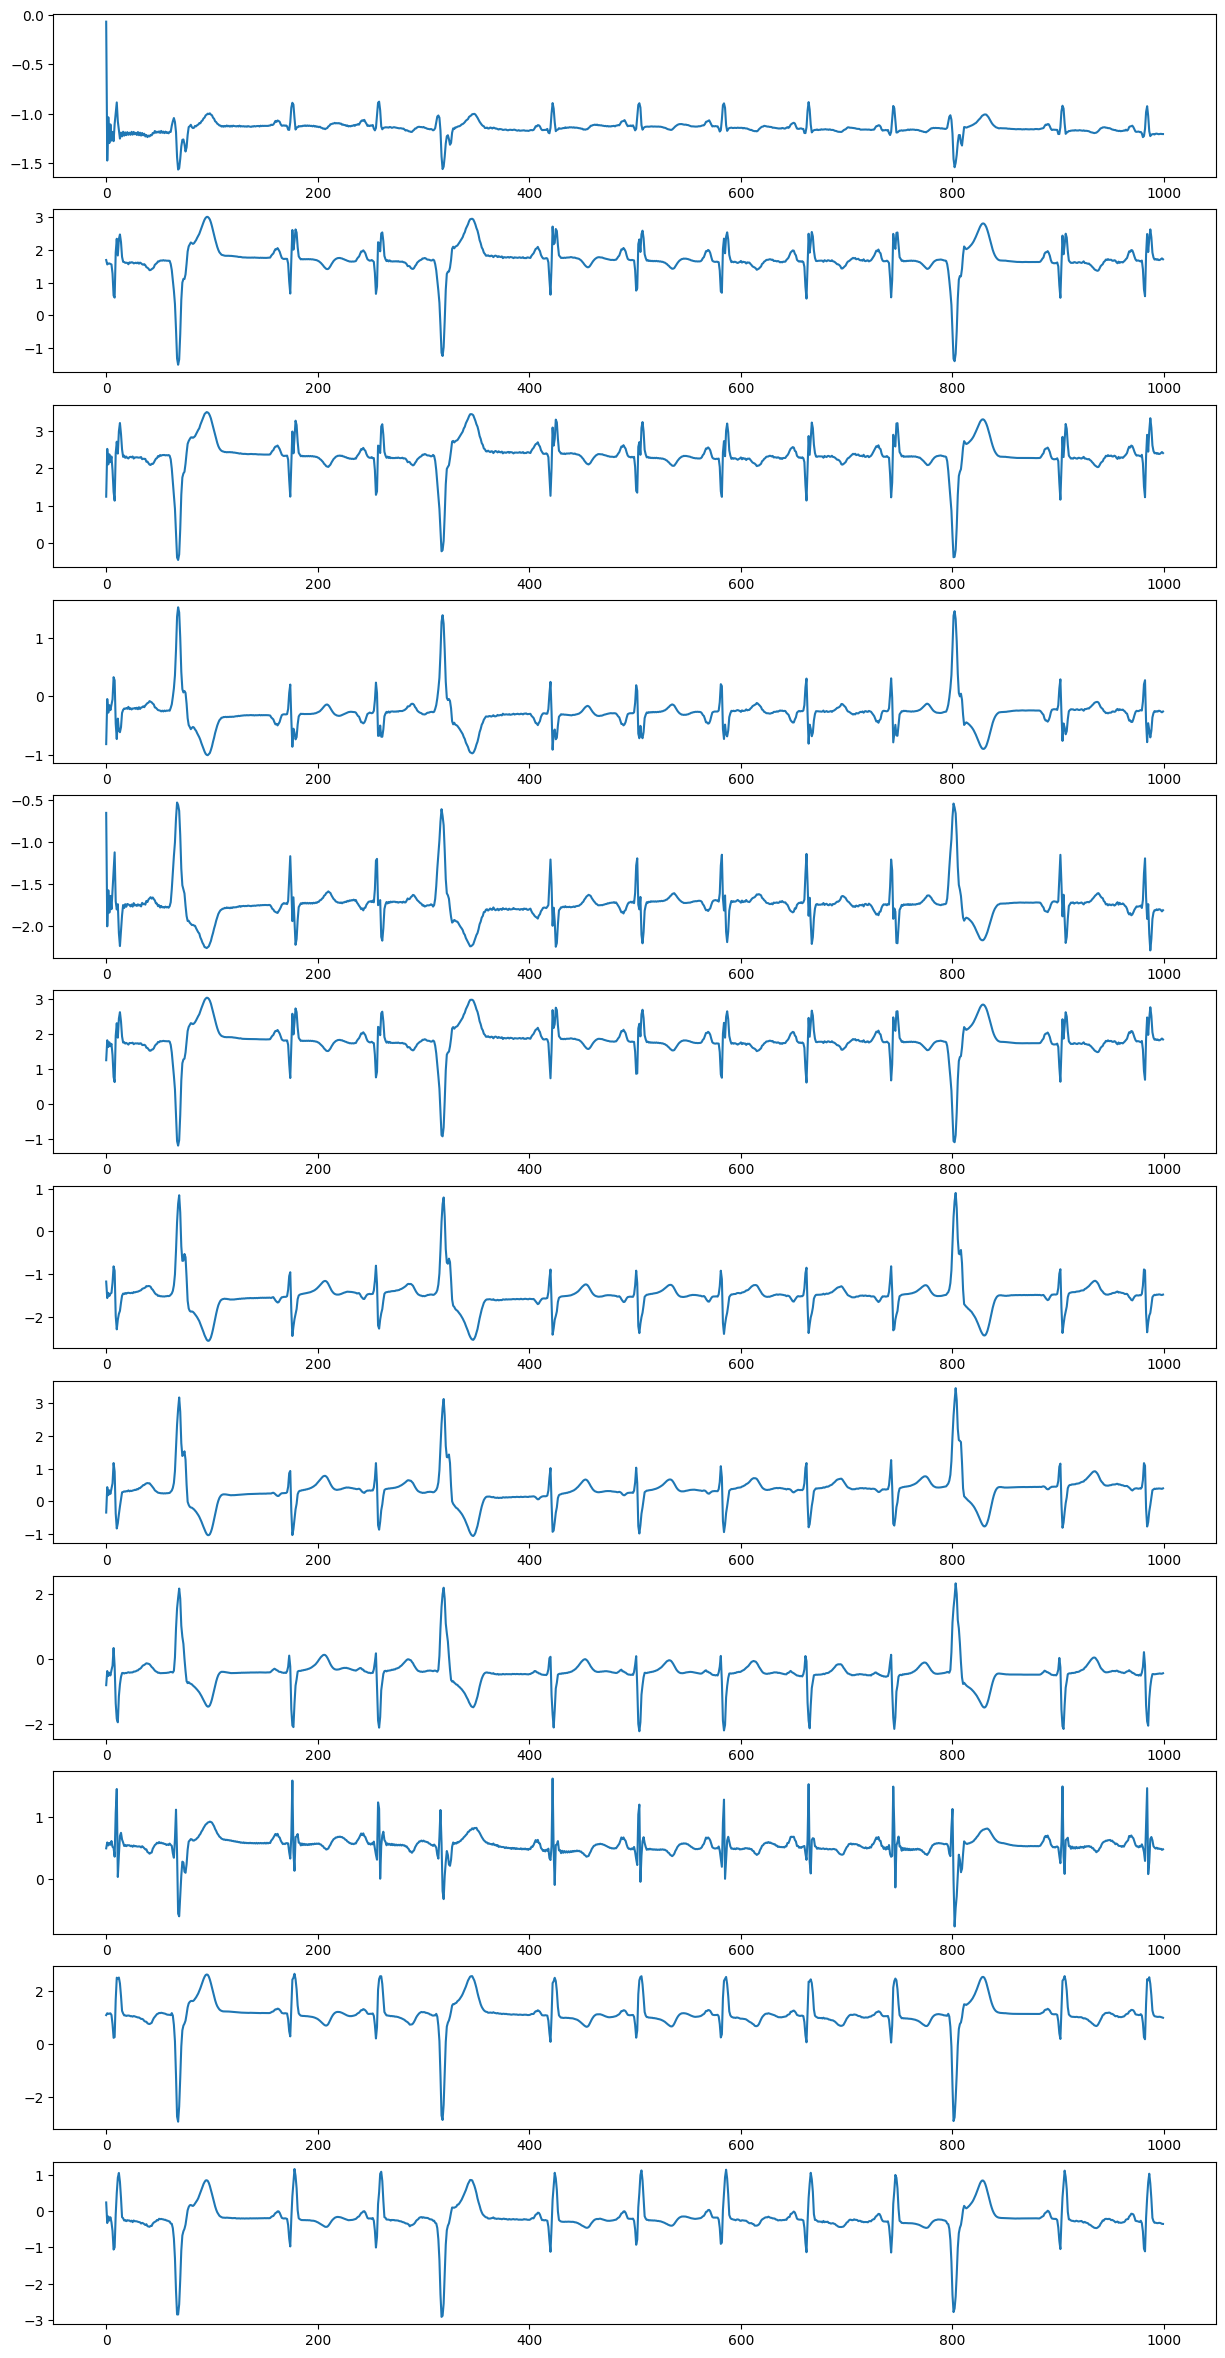

In [118]:
fig, ax = plt.subplots(12, 1, figsize=(15, 30))
for i, axis in enumerate(ax):
    axis.plot(signals_downsamp[0, :, i])

In [31]:
@numba.jit
def remove_baseline_ecg(signal, wavelet='db6', level=6):
    result = np.zeros_like(signal)
    for i in range(signal.shape[0]):
        coeffs = pywt.wavedec(signal[i], wavelet, level=level)
        coeffs[0] *= 0
        result[i, :] = pywt.waverec(coeffs, wavelet)
    return result

/tmp/ipykernel_56219/3685254558.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def remove_baseline_ecg(signal, wavelet='db6', level=6):


In [32]:
@numba.jit(parallel=True)
def remove_baseline_for_all(data_np):
    results = np.zeros_like(data_np)
    num_records = data_np.shape[0]
    
    for i in range(num_records):
        results[i] = remove_baseline_ecg(data_np[i])
    
    return results

/tmp/ipykernel_56219/3743153709.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=True)


In [33]:
signal.shape

(462600, 12)

In [34]:
res = remove_baseline_for_all(signal.T[None, :])
res.shape

/tmp/ipykernel_56219/3743153709.py:7: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is deprecated behaviour that will be removed in Numba 0.59.0.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../tmp/ipykernel_56219/3685254558.py", line 1:
<source missing, REPL/exec in use?>

  results[i] = remove_baseline_ecg(data_np[i])
/tmp/ipykernel_56219/3743153709.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "remove_baseline_ecg" failed type inference due to: Unknown attribute 'wavedec' of type Module(<module 'pywt' from '/home/nabeel/.local/lib/python3.10/site-packages/pywt/__init__.py'>)

File "../../../../tmp/ipykernel_56219/3685254558.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipy

(1, 12, 462600)

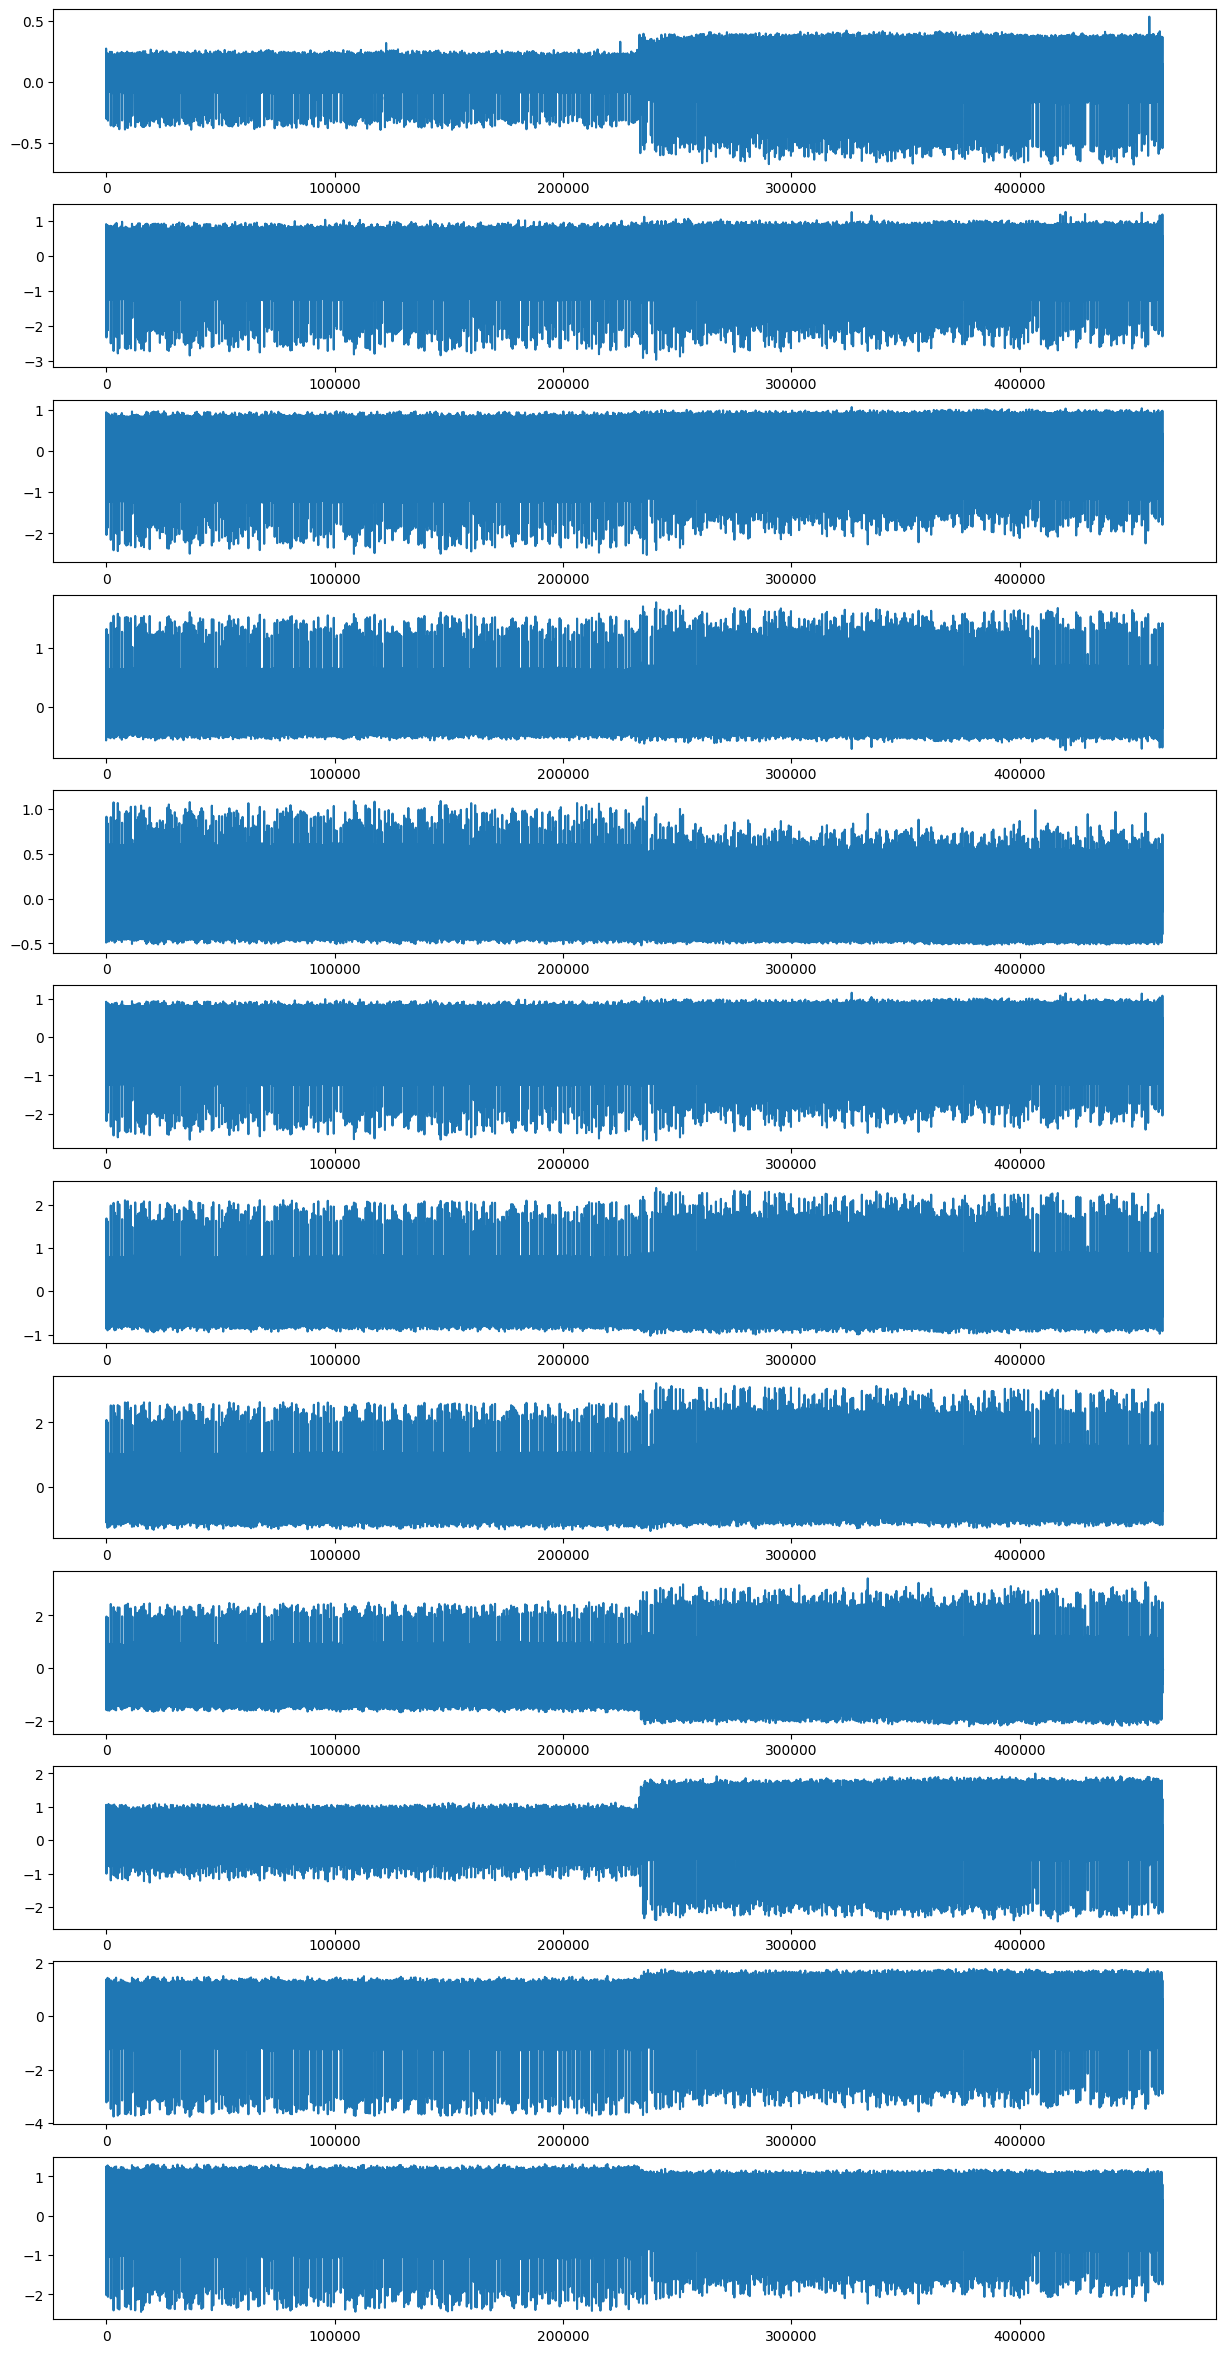

In [35]:
fig, ax = plt.subplots(12, 1, figsize=(15, 30))
for i, axis in enumerate(ax):
    axis.plot(res[0, i, :])

In [41]:
diseases = []
signals = []
for r in records:
    signal, description = wfdb.rdsamp(f"{data_path}/{r}")
    comments = description['comments'][0]
    tag = "<diagnoses>"
    idx = comments.find(tag)
    if idx == -1:
        diagnosis = "Normal"
    else:
        diagnosis = comments[idx+len(tag):].strip()
    diseases.append(diagnosis)
    signal = resample(signal, num=int(new_signal_length))
    signals.append(signal.T)

In [39]:
# pd.Series(diseases)

In [42]:
all_signals = np.stack(signals)

In [43]:
all_signals.shape

(75, 12, 180000)

In [44]:
baseline_removed = remove_baseline_for_all(all_signals)

/tmp/ipykernel_48078/3743153709.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "remove_baseline_for_all" failed type inference due to: Invalid use of type(CPUDispatcher(<function remove_baseline_ecg at 0x7f717685d120>)) with parameters (array(float64, 2d, A))

During: resolving callee type: type(CPUDispatcher(<function remove_baseline_ecg at 0x7f717685d120>))
During: typing of call at /tmp/ipykernel_48078/3743153709.py (7)


File "../../../../tmp/ipykernel_48078/3743153709.py", line 7:
<source missing, REPL/exec in use?>

  @numba.jit(parallel=True)
/tmp/ipykernel_48078/3743153709.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "remove_baseline_for_all" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../../../../tmp/ipykernel_48078/3743153709.py", line 6:
<source missing, REPL/exec in use?>

  @numba.jit(p

In [46]:
baseline_removed.shape

(75, 12, 180000)

In [54]:
df = pd.DataFrame(diseases, columns=["labels"])
df.to_parquet(os.path.join(data_path, "baseline_removed_100hz_incartdb_labels.parquet"))

In [6]:
baseline_removed = np.load(os.path.join(data_path, "baseline_removed_100hz_incartdb.npz"))

In [36]:
df = pd.read_parquet(os.path.join(data_path, "baseline_removed_100hz_incartdb_labels.parquet"))

In [39]:
df['labels'].value_counts() * 180

labels
Normal                                                                          6120
Coronary artery disease, arterial hypertension, left ventricular hypertrophy    1980
Earlier MI                                                                      1620
Transient ischemic attack                                                       1260
Coronary artery disease, arterial hypertension                                  1080
Acute MI                                                                        1080
Sinus node dysfunction                                                           360
Name: count, dtype: int64

In [40]:
array = baseline_removed['arr_0']

In [43]:
array.T.shape

(180000, 12, 75)

In [53]:
rand = np.random.randn(50)
rand

array([ 1.05846149,  1.56056448,  0.77452668,  0.22463879, -0.74028194,
        0.85704629,  0.66272959, -0.62647242, -1.88538288, -1.10307852,
        1.47897313,  1.14745379, -1.13343195, -0.89233191,  0.76719516,
        0.07308486, -0.77644545,  0.31139068,  1.08534992, -0.95838842,
       -0.05809352, -1.15707765, -1.19701425,  0.65577826,  1.21195603,
        0.34125638, -2.09208989, -0.61420533, -0.9222658 ,  0.75679361,
        0.59330695, -1.25601183,  0.03592577, -0.30922791,  0.11956469,
       -0.93137532, -0.46391304,  0.23109376, -1.5374951 ,  0.86088387,
        1.53982399,  1.51719311, -1.55130191, -0.16363712,  1.68665921,
       -0.47198434,  0.07564064,  0.84759135,  0.70583397,  0.14786736])

In [54]:
rand.reshape(5, 10)

array([[ 1.05846149,  1.56056448,  0.77452668,  0.22463879, -0.74028194,
         0.85704629,  0.66272959, -0.62647242, -1.88538288, -1.10307852],
       [ 1.47897313,  1.14745379, -1.13343195, -0.89233191,  0.76719516,
         0.07308486, -0.77644545,  0.31139068,  1.08534992, -0.95838842],
       [-0.05809352, -1.15707765, -1.19701425,  0.65577826,  1.21195603,
         0.34125638, -2.09208989, -0.61420533, -0.9222658 ,  0.75679361],
       [ 0.59330695, -1.25601183,  0.03592577, -0.30922791,  0.11956469,
        -0.93137532, -0.46391304,  0.23109376, -1.5374951 ,  0.86088387],
       [ 1.53982399,  1.51719311, -1.55130191, -0.16363712,  1.68665921,
        -0.47198434,  0.07564064,  0.84759135,  0.70583397,  0.14786736]])

In [76]:
# reshaped = array.reshape(75*180, 12, 1000) # wrong, messes up the order

In [89]:
array.shape

(75, 12, 180000)

In [90]:
total = 75*180

In [91]:
total

13500

In [93]:
# get 220th signal

In [97]:
220 // 180

1

In [104]:
220 % 180

40

In [109]:
array[0, :, 40*1000: 41*1000].shape

(12, 1000)

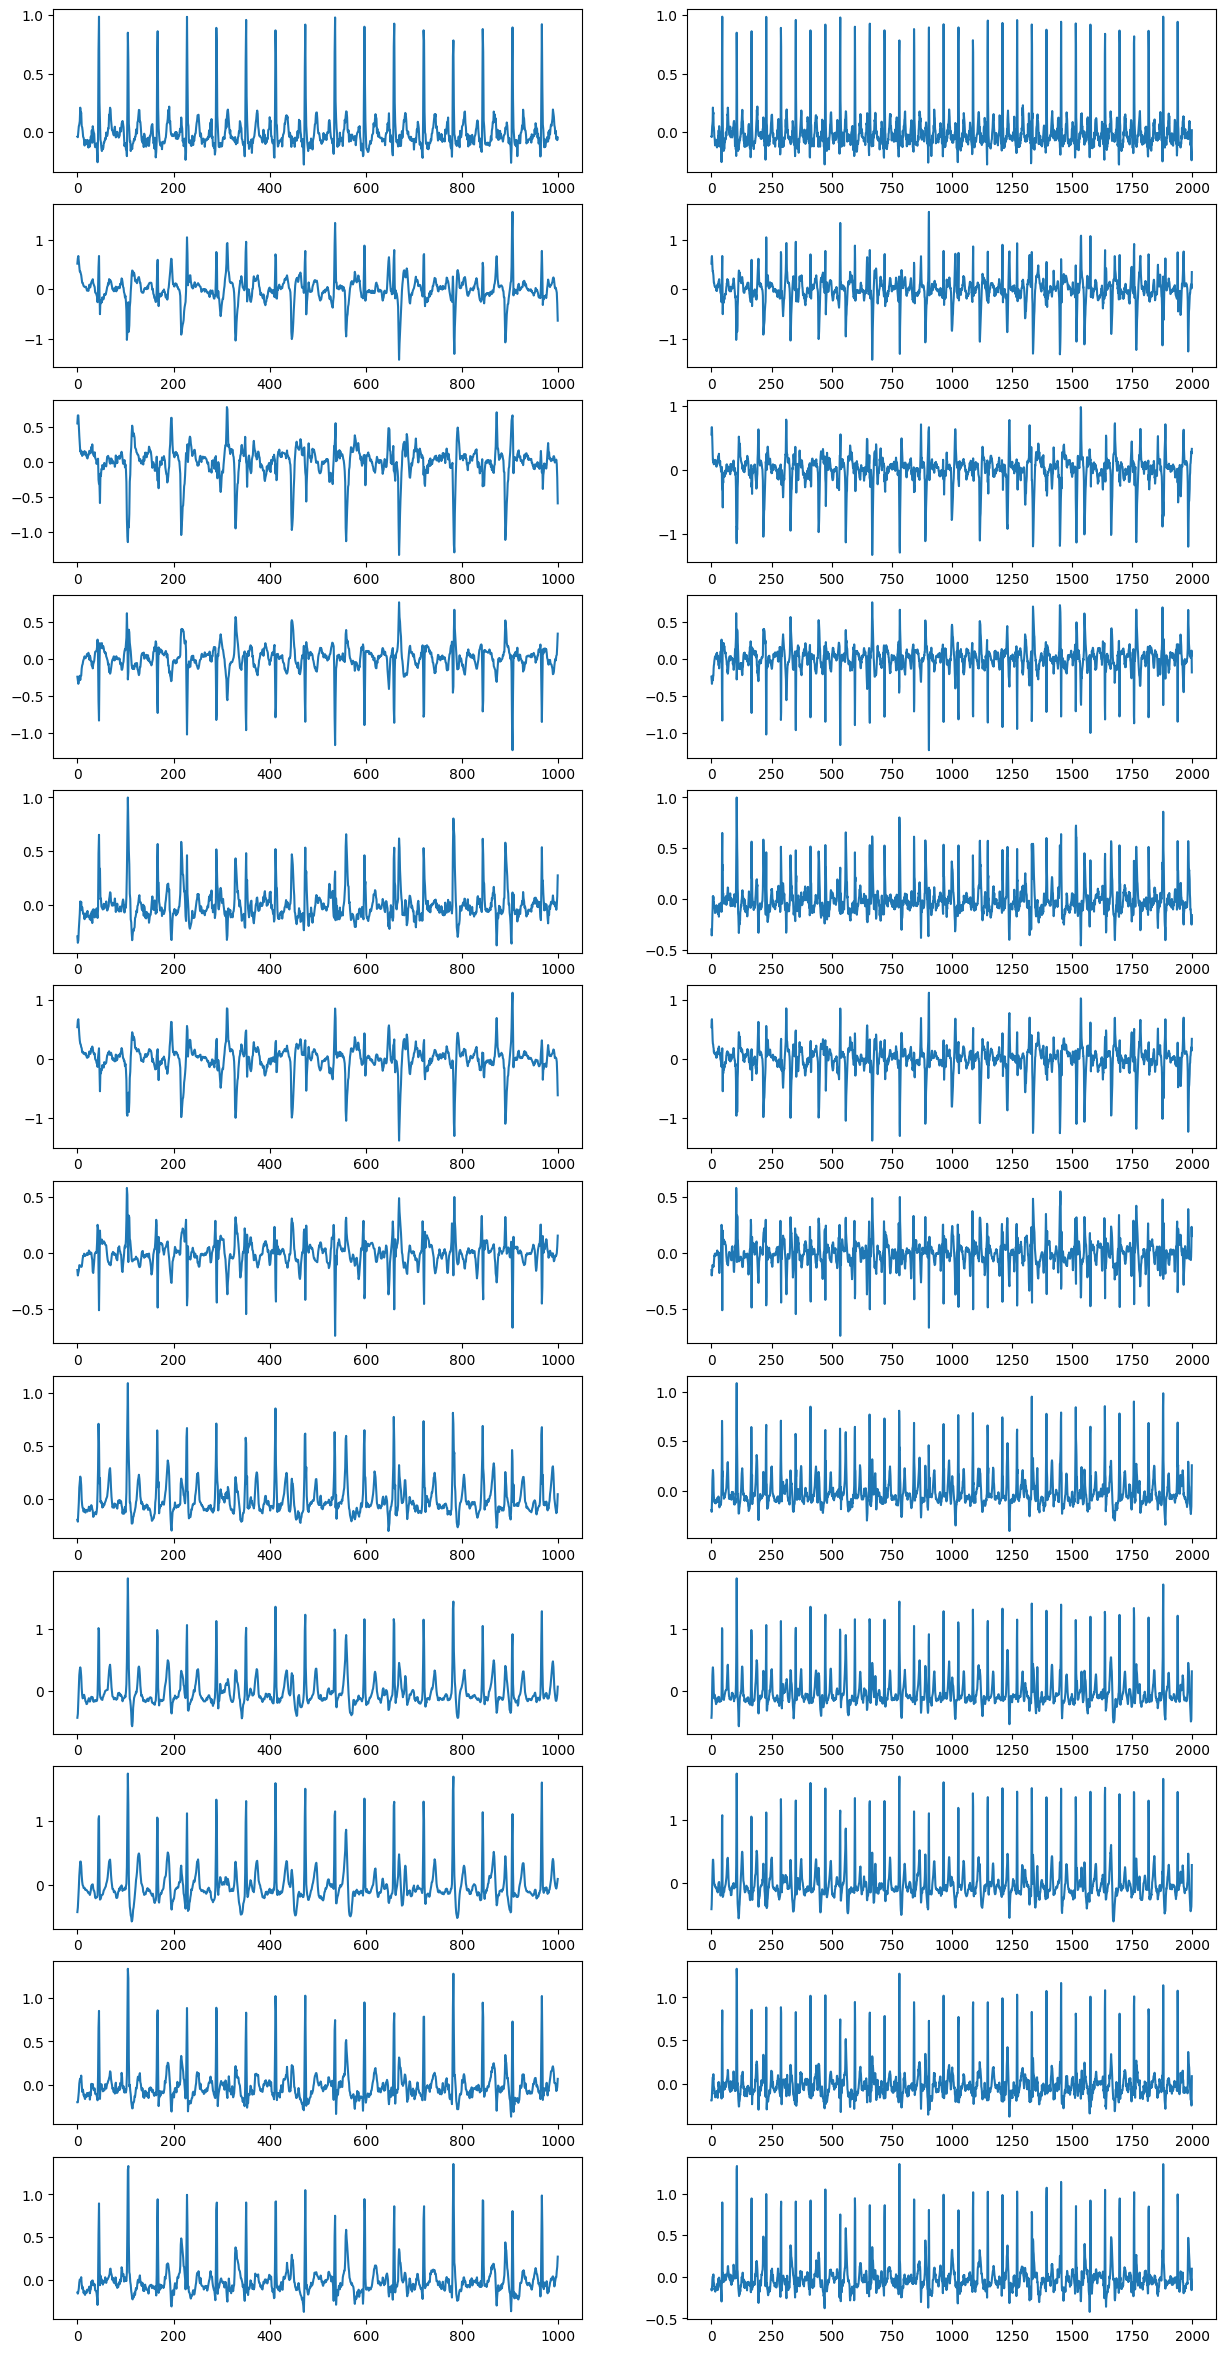

In [112]:
fig, ax = plt.subplots(12, 2, figsize=(15, 30))
for i in range(12):
    ax[i, 0].plot(array[0, i, 40*1000: 41*1000])
    ax[i, 1].plot(array[0, i, 40000: 42000])

In [113]:
75*180

13500